In [92]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
import scipy.io
from math import sqrt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image

In [93]:
def get_distance_2_pts(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    distance = sqrt((y1-y2)**2+(x2-x1)**2)
    return distance

In [94]:
# w is the length of the rectangle
def get_4_pts(p1,p2,img):
    x_max,y_max,_ = img.shape
    x1,y1 = p1
    x2,y2 = p2
    alpha = sqrt((y1-y2)**2+(x2-x1)**2)
    
    if alpha > 200 :
        w = -125
    else:
        w = -250
    
    sin_theta = (y1-y2)/alpha
    cos_theta = (x2-x1)/alpha
    x4 = w*sin_theta + x2
    x3 = w*sin_theta + x1
    y4 = w*cos_theta + y2
    y3 = w*cos_theta + y1
    if (x4 > x_max):
        x4 = x_max
    if (x3 > x_max):
        x3 = x_max
    if (y4 > y_max):
        y4 = y_max
    if (y3 > y_max):
        y3 = y_max
    if (x4 < 0):
        x4 = 0
    if (x3 < 0):
        x3 = 0
    if (y4 < 0):
        y4 = 0
    if (y3 < 0):
        y3 = 0
    p3 = [x3,y3]
    p4 = [x4,y4]
    return p1,p2,p3,p4

In [95]:
def get_slots_model(img,model_slot_dict):
    
    x1 = model_slot_dict['x1']
    y1 = model_slot_dict['y1']
    x2 = model_slot_dict['x2']
    y2 = model_slot_dict['y2']
    p1 = [x1,y1]
    p2 = [x2,y2]
    pts = get_4_pts(p1,p2,img)
    _,_,p3,p4 = pts
    #get slot only image(s)
    pts_src = np.array([p1,p2,p3,p4],np.float32)    
    width = get_distance_2_pts(p1,p2)
    height = get_distance_2_pts(p4,p2)
    pts_dst = np.array([[0.0,0.0],[width, 0.0],[ 0.0,height],[width,height]],np.float32)
    m_warp = cv2.getPerspectiveTransform(pts_src, pts_dst)
    warp_img = cv2.warpPerspective(img, m_warp, (int(width), int(height)))
    return warp_img

In [96]:
def get_slots(img,mat):
    warped_images_with_vacancy = []
    for s in mat['slots']:
        #get the four points
        p1_num = s[0] - 1
        p2_num = s[1] - 1
        p1 = mat['marks'][p1_num]
        p2 = mat['marks'][p2_num]
        pts = get_4_pts(p1,p2,img)
        _,_,p3,p4 = pts
        #get slot only image(s)
        pts_src = np.array([p1,p2,p3,p4],np.float32)    
        width = get_distance_2_pts(p1,p2)
        height = get_distance_2_pts(p4,p2)
        pts_dst = np.array([[0.0,0.0],[width, 0.0],[ 0.0,height],[width,height]],np.float32)
        m_warp = cv2.getPerspectiveTransform(pts_src, pts_dst)
        warp_img = cv2.warpPerspective(img, m_warp, (int(width), int(height)))
        warped_images_with_vacancy.append([warp_img,pts])
    return warped_images_with_vacancy

In [97]:
def img_resize(img):
    #if x >> y rotate 90 degress
    if (img.shape[0]/img.shape[1]) >= 1.3 :
        img =  cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img = cv2.resize(img, (120,46))
    return img

In [98]:
class VPSNet(nn.Module):
    def __init__(self,num_classes = 3):
        super(VPSNet,self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 40, kernel_size=(3, 9), stride=(1, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Conv2d(40, 80, kernel_size=(3, 5), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=(1, 0)),
            nn.Conv2d(80, 120, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(120, 160, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(160 * 5 * 5, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    def forward(self,x):
        x = self.model(x)
        return x

In [99]:
def image_loader(image):
    loader = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    image = loader(image).float()
    image = Variable(image)
    image = image.unsqueeze(0)
    return image.cuda()

def pred_image(model,img_name):
    img = image_loader(img_name)
    prediction = model(img)
    prediction = torch.argmax(prediction.data).cpu().item()
    classification = 'vacant'
    if (prediction == 2):
        classification = 'vacant'
    elif (prediction == 0):
        classification = 'non-vacant'
    elif (prediction == 1):
        classification = 'parking'
    return classification

In [112]:
def draw_classification(img,pts,classification):
    p1,p2,p3,p4 = pts
    x3,y3 = p3
    x2,y2 = p2
    x1,y1 = p1
    x4,y4 = p4
    x_mid = (x4 + x1)/2
    y_mid = (y4 + y1)/2
    p_mid = (int(x_mid),int(y_mid))
    font = cv2.FONT_ITALIC
    img = cv2.putText(img,classification, p_mid, font, 1, (255, 255, 255), 3, cv2.LINE_AA)
    return img

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [114]:
path = 'model_save/98_test.pth'
model = VPSNet()
model.load_state_dict(torch.load(path))
model = model.cuda()

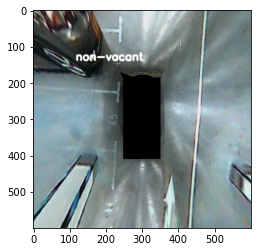

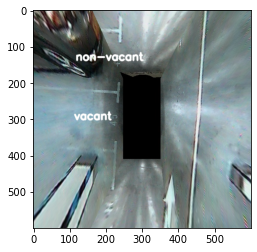

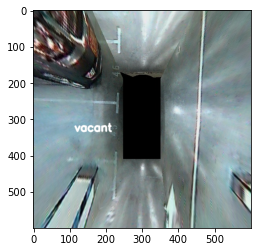

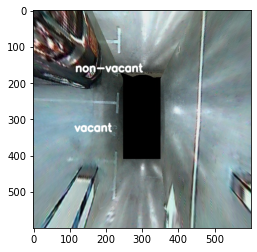

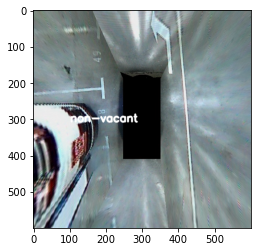

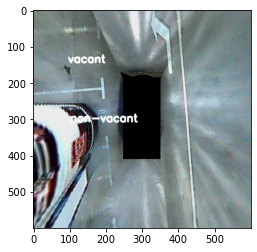

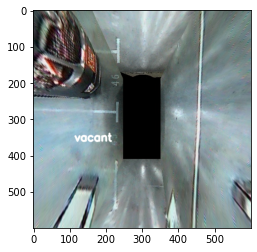

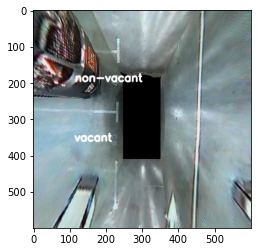

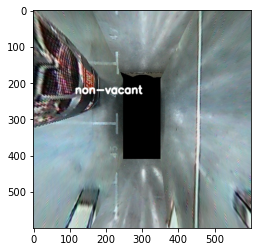

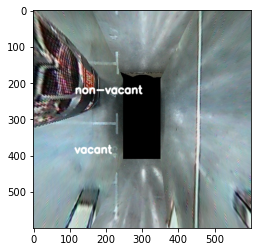

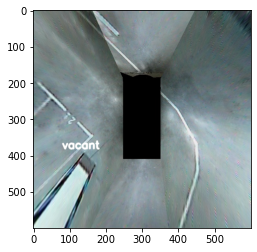

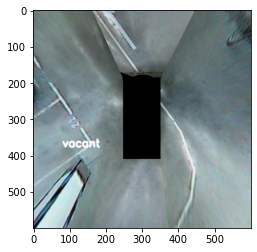

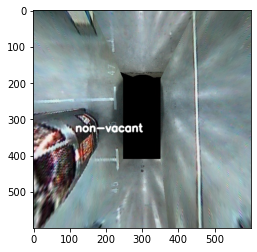

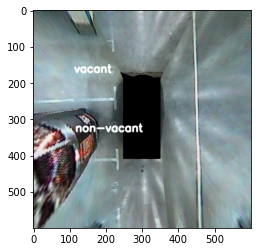

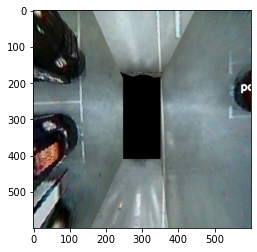

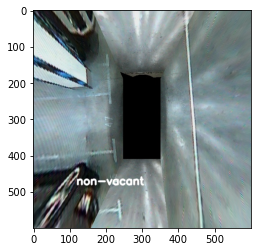

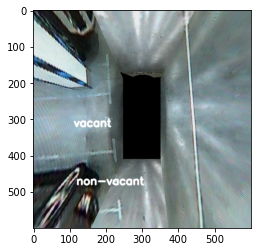

In [117]:
iterator = 0
num_samples = 10
training_dir = 'training/'
for file in glob.glob(training_dir + '*.jpg'):
    file_name = file[:-4]
    img = cv2.imread(file)
    mat = scipy.io.loadmat(file_name + '.mat')
    warped_images_with_vacancy = get_slots(img,mat)
    for image,pts in warped_images_with_vacancy:
        image = img_resize(image)
        classification = pred_image(model,image)
        img = draw_classification(img,pts,classification)
        plt.imshow(img)
        plt.show()
        cv2.imwrite('inference'+str(iterator)+'.jpg',img)
    iterator += 1
    if iterator >= num_samples:
        break